In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler

import cmdstanpy
from cmdstanpy import CmdStanModel

In [ ]:
df = pd.read_csv("df_balanced.csv")

In [ ]:
stan_code = r"""
data {
  int<lower=1> N;                         // total observations
  int<lower=1> I;                         // number of donors
  int<lower=1> K;                         // number of target variables (K = 5)
  int<lower=1> P;                         // number of covariates

  array[N] int<lower=1, upper=I> id;      // donor index for each observation
  matrix[N, K] Y;                         // log target variables
  matrix[N, P] X;                         // covariate matrix

  real<lower=K> a_Sigma;
  real<lower=0> b_Sigma;

  real<lower=0> tau0;
}

parameters {
  // Regularized horseshoe for fixed effects
  matrix[P, K] beta_tilde;                // standardized coefficients
  vector<lower=0>[P] lambda;              // local shrinkage for each covariate
  real<lower=0> tau;                      // global shrinkage
  real<lower=0> c2_tilde;                 // slab parameter (unscaled)

  // donor-specific random effects (I x K)
  matrix[I, K] b;

  // hyperparameters for random effects
  row_vector[K] mu_b;
  cov_matrix[K] Sigma_b;

  // residual covariance across the K outcomes
  cov_matrix[K] Sigma;
}

transformed parameters {
  // actual fixed effects after applying regularized horseshoe
  matrix[P, K] beta;
  real<lower=0> c2;

  c2 = square(tau) * c2_tilde;  // slab variance

  for (p in 1:P) {
    real lambda_tilde =
      sqrt( (c2 * square(lambda[p])) /
            (c2 + square(tau) * square(lambda[p])) );
    for (k in 1:K) {
      beta[p, k] = beta_tilde[p, k] * lambda_tilde * tau;
    }
  }
}

model {
  // Regularized horseshoe for fixed effects
  to_vector(beta_tilde) ~ normal(0, 1);         // base Gaussian
  lambda ~ cauchy(0, 1);                        // local half-Cauchy (truncated >0)
  tau ~ cauchy(0, tau0);                        // global half-Cauchy, scale = tau0
  c2_tilde ~ inv_gamma(2, 8);                   // slab prior

  //  Prior for random effects
  mu_b ~ normal(0, 1);

  Sigma_b ~ inv_wishart(10,
                        0.5 * diag_matrix(rep_vector(1.0, K)));

  for (i in 1:I) {
    b[i] ~ multi_normal(mu_b, Sigma_b);
  }

  Sigma ~ inv_wishart(a_Sigma,
                      b_Sigma * diag_matrix(rep_vector(1.0, K)));

  // Likelihood
  for (n in 1:N) {
    row_vector[K] mu_n = X[n] * beta + b[id[n]];
    Y[n] ~ multi_normal(mu_n, Sigma);
  }
}

generated quantities {
  vector[N] log_lik;

  for (n in 1:N) {
    row_vector[K] mu_n = X[n] * beta + b[id[n]];
    log_lik[n] = multi_normal_lpdf(Y[n] | mu_n, Sigma);
  }
}

"""

stan_file = "Model_1_SESSO.stan"
with open(stan_file, "w") as f:
    f.write(stan_code)

print("Stan model written to:", stan_file)

Stan model written to: Model_1_SESSO.stan


In [ ]:
model = CmdStanModel(stan_file=stan_file)
ID_COL = "CAI"
ADD_INTERCEPT = False
target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
covariate_cols = df.columns.drop(list(target_list) + [ID_COL])

cols_needed = [ID_COL] + target_list + list(covariate_cols)
df_model = df[cols_needed].dropna().copy()

Y_mat = df_model[target_list].to_numpy(dtype=float)
N, K = Y_mat.shape
X_mat = df_model[covariate_cols].to_numpy(dtype=float)
_, P = X_mat.shape

donor_ids, id_index = np.unique(df_model[ID_COL].to_numpy(), return_inverse=True)
I = len(donor_ids)
id_stan = id_index + 1

stan_data = {
    "N": int(N),
    "I": int(I),
    "K": int(K),
    "P": int(P),
    "Y": Y_mat,
    "X": X_mat,
    "id": id_stan,
    "a_Sigma": 10.0,
    "b_Sigma": 1.0,
    "tau0": 0.002

}

In [ ]:
fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    iter_warmup=1500,
    iter_sampling=1000,
    adapt_delta=0.9,
    max_treedepth=12,
    show_progress=True
)
print(fit.diagnose())

20:17:06 - cmdstanpy - INFO - CmdStan start processing
chain 2:   0%|                                                                      | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|                                                                      | 0/2500 [00:00<?, ?it/s, (Warmup)]


chain 1:   0%|                                                              | 1/2500 [00:00<10:44,  3.88it/s, (Warmup)]


chain 2:   0%|                                                              | 1/2500 [00:00<15:05,  2.76it/s, (Warmup)]

chain 3:   0%|                                                              | 1/2500 [00:00<15:40,  2.66it/s, (Warmup)]


chain 4:   4%|██▎                                                       | 100/2500 [21:41<8:42:10, 13.05s/it, (Warmup)]


chain 4:   8%|████▋                                                     | 200/2500 [24:22<4:01:58,  6.31s/it, (Warmup)]

chain 3:   4%|██▎                                                      | 100/2500 [26:00<10:25

KeyboardInterrupt: 

In [ ]:
import os

print("Executable path:", model.exe_file)
print("Exe exists:", os.path.exists(model.exe_file))
print("Exe size:", os.path.getsize(model.exe_file) if os.path.exists(model.exe_file) else "N/A")


In [ ]:
print(fit.diagnose())
summary_df = fit.summary()
summary_df.head(50)

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
10 of 4000 (0.25%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  lambda[19], b[11,1], b[24,1], b[1,2], b[2,2], b[3,2], b[4,2], b[5,2], b[6,2], b[9,2], b[10,2], b[11,2], b[12,2], b[13,2], b[14,2], b[16,2], b[17,2], b[26,2], b[27,2], b[29,2], b[30,2], b[32,2], b[33,2], b[35,2], beta[19,2]
Such high values indicate incomplete mixing and biased estimation.
You should consider regularizing your model with additional prior in

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,10013.600000,0.552088,16.353100,16.038800,9985.910000,10013.800000,10040.000000,894.678,1829.90,0.237933,1.002240
"beta_tilde[1,1]",-0.068992,0.010868,0.664115,0.542386,-1.166080,-0.056581,1.030450,3953.730,2618.19,1.051470,1.001270
"beta_tilde[1,2]",0.728339,0.012023,0.742278,0.672130,-0.478306,0.732482,1.939020,4143.500,2495.93,1.101930,1.000370
"beta_tilde[1,3]",0.718094,0.015723,0.985275,0.954738,-0.952265,0.780117,2.283000,4097.780,2612.93,1.089770,1.000320
"beta_tilde[1,4]",0.466498,0.011318,0.762212,0.688349,-0.761661,0.442405,1.738140,4777.770,2470.36,1.270610,1.001180
"beta_tilde[1,5]",0.501047,0.011229,0.602135,0.481052,-0.380578,0.445045,1.526620,3151.200,1916.07,0.838037,1.000390
"beta_tilde[2,1]",0.281999,0.010599,0.634315,0.541235,-0.727846,0.258929,1.357960,3858.600,2575.46,1.026170,1.007020
"beta_tilde[2,2]",-0.558986,0.010959,0.706514,0.642288,-1.719890,-0.540426,0.575789,4299.700,2985.61,1.143470,1.003050
"beta_tilde[2,3]",0.152117,0.012805,0.913571,0.901999,-1.299200,0.141314,1.681270,5179.510,3177.36,1.377450,0.999838
"beta_tilde[2,4]",1.142370,0.012727,0.759452,0.668965,-0.077575,1.144240,2.391830,3807.820,2700.03,1.012660,1.001390


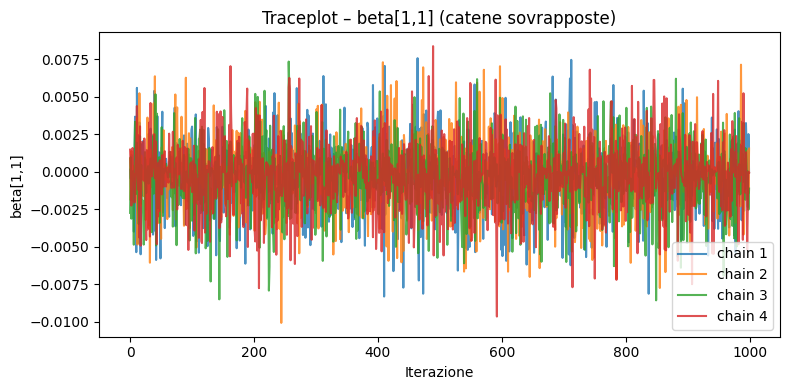

In [ ]:
# Interesting plots

beta = fit.stan_variable("beta")
tot_draws, P, K = beta.shape
chains = fit.chains # number of chains
iters = tot_draws // chains # number of draws per chain

beta_chains = beta.reshape(chains, iters, P, K)

fig, ax = plt.subplots(figsize=(8, 4))

for c in range(chains):
    ax.plot(beta_chains[c, :, 0, 0], label=f"chain {c+1}", alpha=0.8)

ax.set_xlabel("Iterazione")
ax.set_ylabel(f"beta[{0+1},{0+1}]")
ax.set_title(f"Traceplot – beta[{0+1},{0+1}] (catene sovrapposte)")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
with open("Model_1_SESSO.pkl", "wb") as f:
    pickle.dump(fit, f)

In [ ]:
import pickle
with open("Model_1_SESSO.pkl", "rb") as f:
    fit = pickle.load(f)


In [ ]:
import arviz as az
idata = az.from_cmdstanpy(fit, log_likelihood="log_lik")
az.waic(idata)

ModuleNotFoundError: No module named 'arviz'

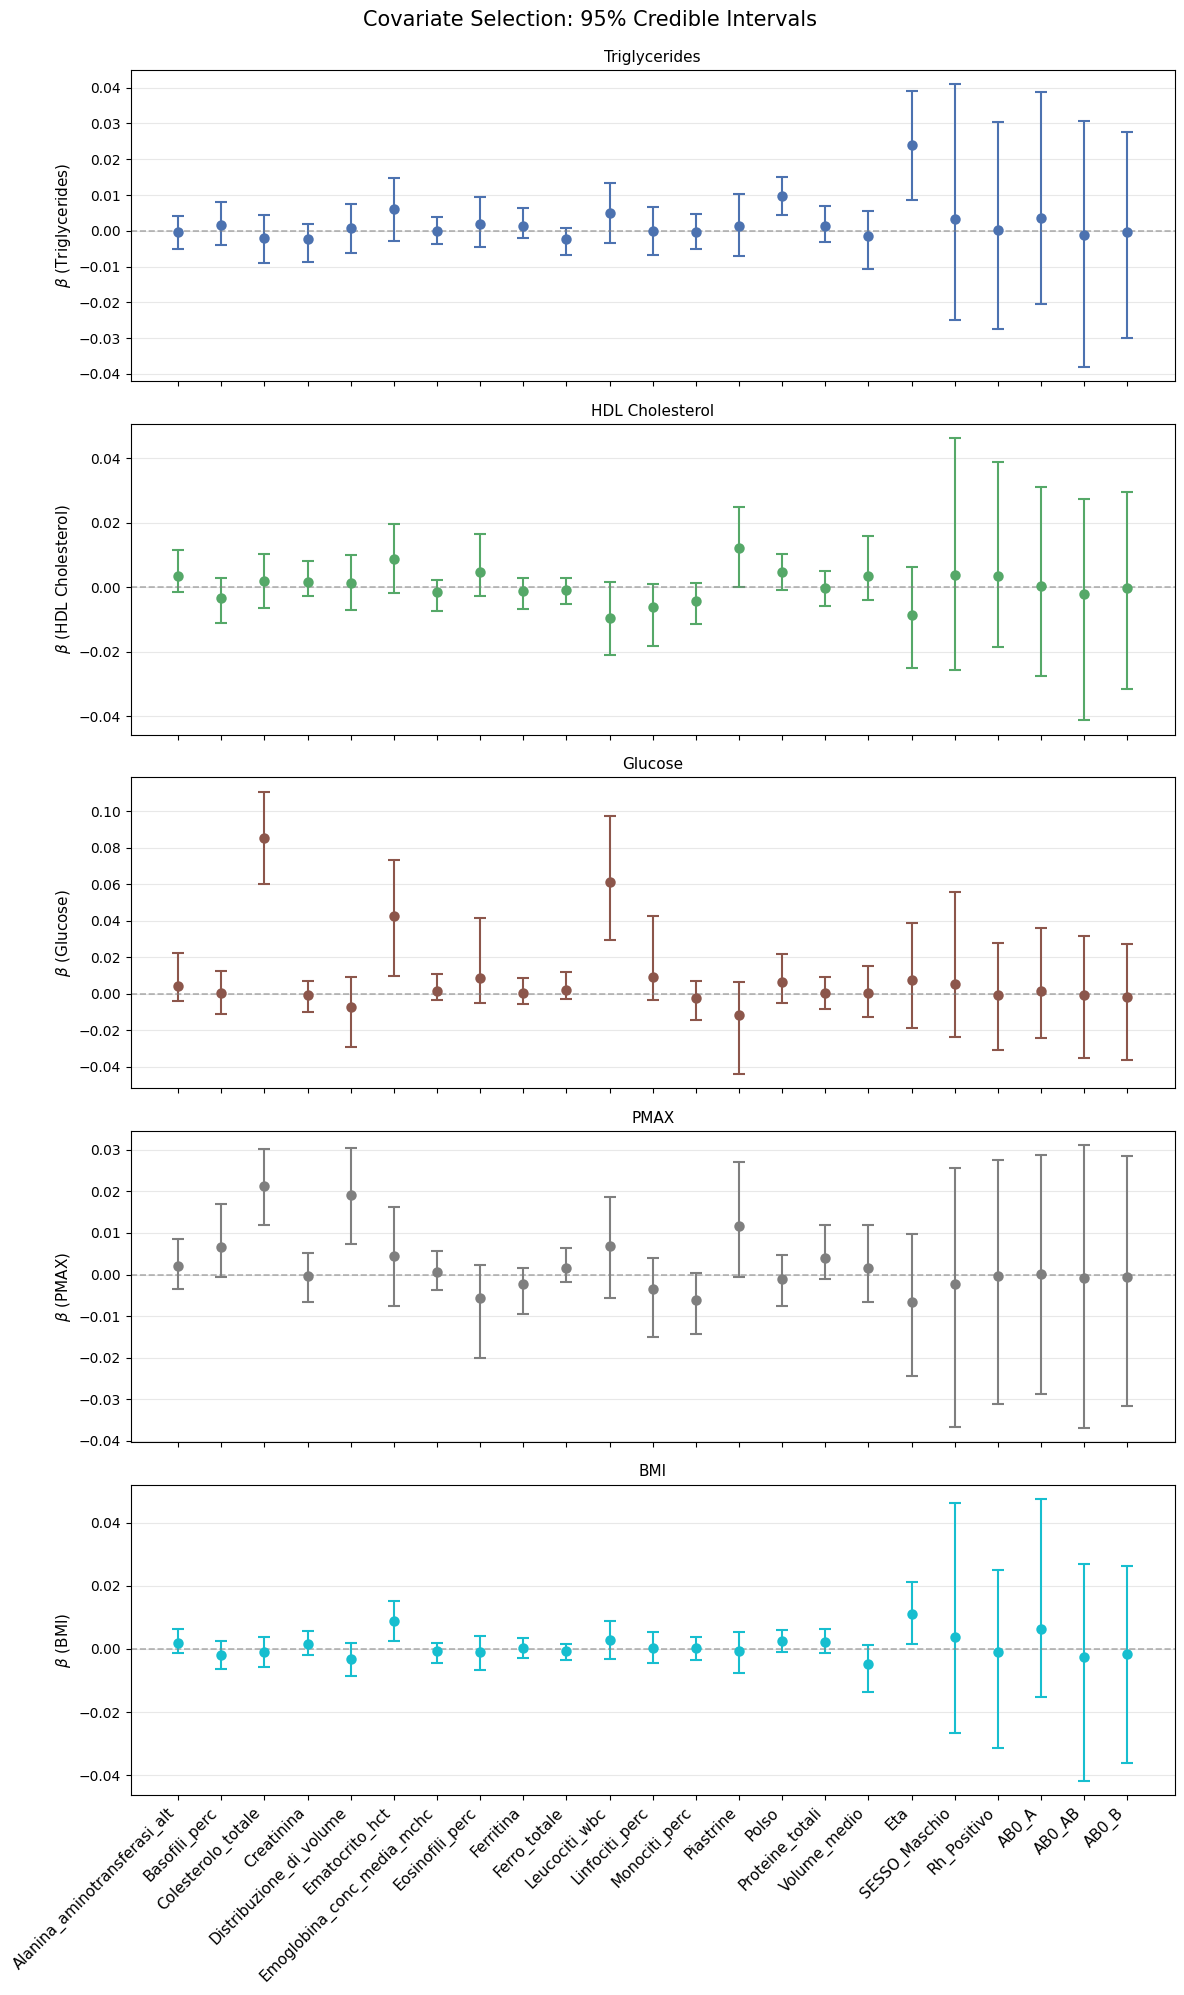

In [ ]:
import matplotlib.pyplot as plt
ID_COL = "CAI"
TARGET_COLS = ["Trigliceridi", "Colesterolo_Hdl", "Glucosio", "PMAX", "BMI"]
numeric_cols = df.select_dtypes(exclude=["object", "category"]).columns.tolist()
COVARIATE_COLS = [c for c in numeric_cols if c not in TARGET_COLS + [ID_COL]]

data = fit.stan_variables()
beta_samples = data['beta']

if beta_samples.ndim == 3 and beta_samples.shape[-1] == 5:
    beta_samples = np.swapaxes(beta_samples, 1, 2)

n_targets = beta_samples.shape[1]
n_features = beta_samples.shape[2]

means = np.mean(beta_samples, axis=0)              # Shape: (n_targets, n_features)
lower = np.percentile(beta_samples, 2.5, axis=0)   # Shape: (n_targets, n_features)
upper = np.percentile(beta_samples, 97.5, axis=0)  # Shape: (n_targets, n_features)

y_pos = np.arange(n_features)
target_names = ['Triglycerides', 'HDL Cholesterol', 'Glucose', 'PMAX', 'BMI']
colors = ['#4c72b0', '#55a868', '#8c564b', '#7f7f7f', '#17becf']

fig, axes = plt.subplots(nrows=n_targets, ncols=1,
                         figsize=(12, 4 * n_targets),
                         sharex=True)

if n_targets == 1: axes = [axes]

for i, ax in enumerate(axes):
    y_mean = means[i, :]
    y_low = lower[i, :]
    y_high = upper[i, :]
    y_err = [y_mean - y_low, y_high - y_mean]
    col = colors[i % len(colors)]
    ax.errorbar(x=y_pos, y=y_mean, yerr=y_err, fmt='o',
                markersize=6, capsize=4,
                color=col, ecolor=col,
                elinewidth=1.5, markeredgewidth=1.5)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1.2, alpha=0.6)
    if i < len(target_names):
        t_name = target_names[i]
    else:
        t_name = f"Target {i+1}"

    ax.set_title(t_name, fontsize=11)
    ax.set_ylabel(fr'$\beta$ ({t_name})', fontsize=11)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)

axes[-1].set_xticks(y_pos)
axes[-1].set_xticklabels(COVARIATE_COLS, rotation=45, ha='right', fontsize=11)

fig.suptitle('Covariate Selection: 95% Credible Intervals', fontsize=15, y=0.995)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*60)
print("CI crossing 0:")
print("="*60)
crosses_zero = (lower < 0) & (upper > 0)
all_zero_mask = np.all(crosses_zero, axis=0)
indices_all_zero = np.where(all_zero_mask)[0]

if len(indices_all_zero) == 0:
    print("\nNone.")
else:
    print(f"\Found {len(indices_all_zero)} covariates crossing 0 on all targets:\n")

    for idx in indices_all_zero:
        feat_name = COVARIATE_COLS[idx]
        print(f"Covariate '{feat_name}' has 5 CI crossing 0:")

        for t_idx, t_name in enumerate(target_names):
            l_val = lower[t_idx, idx]
            u_val = upper[t_idx, idx]
            m_val = means[t_idx, idx]
            print(f"   - {t_name:<15}: [{l_val:.4f}, {u_val:.4f}] (media: {m_val:.4f})")

        print("-" * 40)


CI crossing 0:
\Found 16 covariates crossing 0 on all targets:

Covariate 'Alanina_aminotransferasi_alt' has 5 CI crossing 0:
   - Triglycerides  : [-0.0051, 0.0043] (media: -0.0003)
   - HDL Cholesterol: [-0.0016, 0.0115] (media: 0.0035)
   - Glucose        : [-0.0039, 0.0224] (media: 0.0044)
   - PMAX           : [-0.0034, 0.0085] (media: 0.0020)
   - BMI            : [-0.0012, 0.0062] (media: 0.0020)
----------------------------------------
Covariate 'Basofili_perc' has 5 CI crossing 0:
   - Triglycerides  : [-0.0040, 0.0079] (media: 0.0015)
   - HDL Cholesterol: [-0.0112, 0.0028] (media: -0.0032)
   - Glucose        : [-0.0110, 0.0127] (media: 0.0007)
   - PMAX           : [-0.0005, 0.0170] (media: 0.0067)
   - BMI            : [-0.0064, 0.0024] (media: -0.0018)
----------------------------------------
Covariate 'Creatinina' has 5 CI crossing 0:
   - Triglycerides  : [-0.0087, 0.0019] (media: -0.0022)
   - HDL Cholesterol: [-0.0028, 0.0083] (media: 0.0016)
   - Glucose        : [-

<>:11: SyntaxWarning: "\F" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\F"? A raw string is also an option.
<>:11: SyntaxWarning: "\F" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\F"? A raw string is also an option.
C:\Users\marti\AppData\Local\Temp\ipykernel_36084\3608548925.py:11: SyntaxWarning: "\F" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\F"? A raw string is also an option.
  print(f"\Found {len(indices_all_zero)} covariates crossing 0 on all targets:\n")


In [ ]:
from scipy.special import logsumexp
log_lik = fit.stan_variable("log_lik")
log_lik = log_lik.reshape(-1, log_lik.shape[-1])
S, N = log_lik.shape
lppd_i = logsumexp(log_lik, axis=0) - np.log(S)
p_waic_i = np.var(log_lik, axis=0, ddof=1)
elpd_waic = np.sum(lppd_i - p_waic_i)
waic = -2 * elpd_waic

print("ELPD_WAIC =", elpd_waic)
print("WAIC =", waic)
print("p_WAIC / N =", np.sum(p_waic_i) / N)


ELPD_WAIC = 5399.680528091937
WAIC = -10799.361056183874
p_WAIC / N = 0.19452793935586085
